In [31]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import optuna

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

from catboost import CatBoostClassifier
from catboost import Pool, cv

sns.set()

# Описание данных

Набор данных содержит транзакции, совершенные европейскими держателями карт по кредитным картам в сентябре 2013 года.
В этом наборе данных представлены транзакции, произошедшие за два дня, где у нас есть 492 мошенничества из 284 807 транзакций. Набор данных сильно несбалансирован, на положительный класс (мошенничества) приходится 0,172% всех транзакций.

Он содержит только числовые входные переменные, которые являются результатом преобразования PCA. К сожалению, из-за проблем конфиденциальности мы не можем предоставить исходные характеристики и дополнительную справочную информацию о данных. Столбцы V1, V2,…, V28 являются основными компонентами, полученными с помощью PCA, единственные функции, которые не были преобразованы с помощью PCA, - это `time` и `Amount`.

Столбец `time` содержит секунды, прошедшие между каждой транзакцией и первой транзакцией в наборе данных. 

Столбец `Amount` представляет собой сумму транзакции. 

Столбец `class` содержит мошеннические (1) и немошеннические (0) транзакции


In [2]:
df = pd.read_csv('creditcard.csv')
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


# EDA

Учитывая то, что смысл подавляющей части данных неизвестен, особое внимание уделим стобцам `time` и `Amount`

Можно предположить что столбец `time` в таком формате не будет коррелировать с меткой класса

Удалим из данных дубликаты

In [3]:
df.drop_duplicates(inplace=True)

Все столбцы имеют сильный разброс значений, для адекватной работы линейных моделей потребуется их нормализация 

In [4]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,...,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,94811.077600,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,-0.001596,...,-0.000371,-0.000015,0.000198,0.000214,-0.000232,0.000149,0.001763,0.000547,88.472687,0.001667
std,47481.047891,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,1.095492,...,0.723909,0.724550,0.623702,0.605627,0.521220,0.482053,0.395744,0.328027,250.399437,0.040796
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54204.750000,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,...,-0.228305,-0.542700,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,5.600000,0.000000
50%,84692.500000,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,...,-0.029441,0.006675,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288,22.000000,0.000000
75%,139298.000000,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,...,0.186194,0.528245,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276,77.510000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


В данной задаче имеется сильный дисбаланс классов. Для оценки качества модели будем использовать метрику Recall

In [5]:
df['Class'].value_counts()

Class
0    283253
1       473
Name: count, dtype: int64

Можно заметить, что столбцы `V1`-`V29` не скоррелированы между собой. Это можно сразу установить из того, что данные признаки получены при помощи анализа главных компонент, PCA

Также стоит отметить, что столбец `time` и `amount` не скоррелированы с целевой переменной `class`, возможно стоит преобразовать их каким-либо образом к другому виду

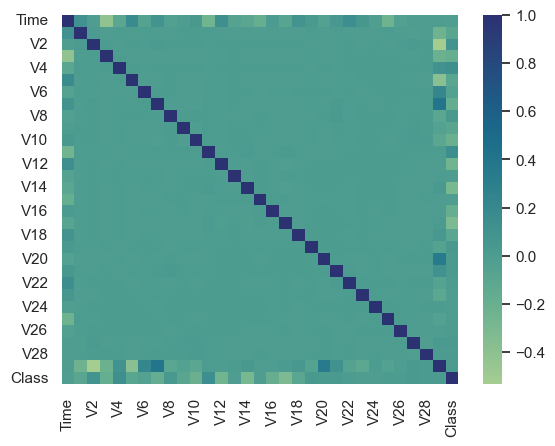

In [6]:
sns.heatmap(df.corr(), cbar=True, cmap="crest")
plt.show()

Посмотрим на несколько _scaterplot_

<AxesSubplot: xlabel='V1', ylabel='V2'>

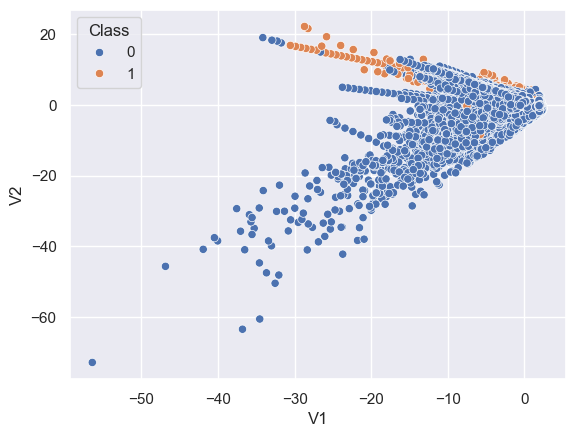

In [7]:
sns.scatterplot(df, x = df['V1'], y = df['V2'], hue=df['Class'])

<AxesSubplot: xlabel='V1', ylabel='V3'>

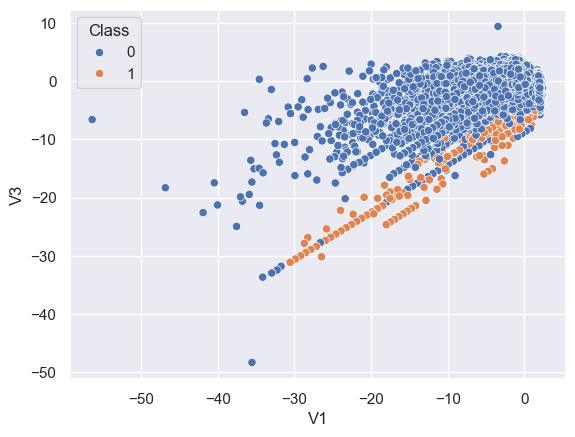

In [8]:
sns.scatterplot(df, x = df['V1'], y = df['V3'], hue=df['Class'])

<AxesSubplot: xlabel='V2', ylabel='V3'>

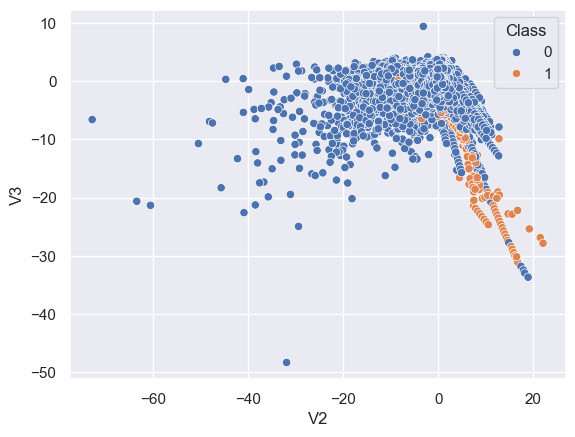

In [9]:
sns.scatterplot(df, x = df['V2'], y = df['V3'], hue=df['Class'])

Даже по представленным графикам можно заметить, что классы линейно не разделимы, однако некоторые закономерности присутствуют

# Baseline

В силу большого объема данных, для начала, попробуем решить задачу логистической регрессией, выбор обусловлен так же тем, что она 'из коробки' умеет работать с несбалансированными классами

Удалим из матрицы объект-признак столбец `time`

In [10]:
X = df.drop(['Class'], axis = 1)
y = df.Class

Разделим данные на обучающую и тестовую части

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

Данные разбились пропорционально меткам класса

In [12]:
y_train.value_counts(), y_test.value_counts()

(Class
 0    198277
 1       331
 Name: count, dtype: int64,
 Class
 0    84976
 1      142
 Name: count, dtype: int64)

Основные статистики обучающей и тестовой выборок практически совпадают

In [13]:
X_train.describe()-X_test.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,...,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000
mean,349.321162,-0.002689,-0.000255,0.002039,0.010443,0.010629,0.002622,-0.000741,0.002758,-0.006590,...,0.001912,0.003912,-0.000073,-0.001938,0.001932,-0.001253,0.000507,-0.000846,0.003402,-0.503359
std,15.555743,-0.002333,-0.001586,-0.008102,0.017189,-0.064794,-0.023878,-0.094303,-0.016544,-0.002261,...,-0.049513,0.009040,0.000473,-0.012400,-0.002718,-0.001623,-0.003465,-0.015500,0.005570,-25.075175
min,-1.000000,-18.849443,-9.371029,14.644605,-0.123054,81.651178,-4.231194,-10.317913,-22.528299,-2.591540,...,30.850830,-11.941035,1.433721,11.978740,0.011778,1.598770,-0.070221,-12.670435,3.719188,0.000000
25%,238.500000,0.000747,0.003226,0.007934,0.002752,0.004931,0.003387,0.000541,0.000074,-0.001479,...,0.000850,-0.000129,0.002692,-0.000655,0.001579,-0.002673,0.001735,0.000533,0.001122,0.210000
50%,352.000000,-0.011077,0.002021,-0.007644,0.001674,0.005545,-0.002510,0.001078,0.001109,-0.001981,...,0.000647,0.001309,-0.000184,-0.001124,0.000439,-0.001868,0.001958,-0.000102,0.000847,0.180000
75%,272.750000,-0.003153,0.006808,-0.000498,0.013695,0.005580,0.004482,0.006003,0.000725,-0.005851,...,0.000617,0.000876,0.001640,0.000833,0.001836,-0.000798,-0.002883,0.001037,0.001940,0.700000
max,6.000000,0.015723,4.639080,5.280842,0.159807,1.890204,-51.908557,-86.286317,-0.419436,5.202106,...,-1.303695,7.139053,2.230857,0.444867,-0.568207,1.448738,0.054100,-19.459797,17.981087,-6781.160000


In [14]:
baseline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(class_weight = 'balanced'))
])

In [15]:
baseline.fit(X_train, y_train)
pred = baseline.predict(X_test)

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     84976
           1       0.05      0.89      0.10       142

    accuracy                           0.97     85118
   macro avg       0.53      0.93      0.54     85118
weighted avg       1.00      0.97      0.98     85118



Итого, модель имеет большой recall и очень маленький precision на положительном классе, значит наша модель нашла очень мало мошеннических транзакций, но при этом 87% объектов, отнесенных к мошенническим транзакциям действительно оказались мошенническими.

Построим  ROC кривую

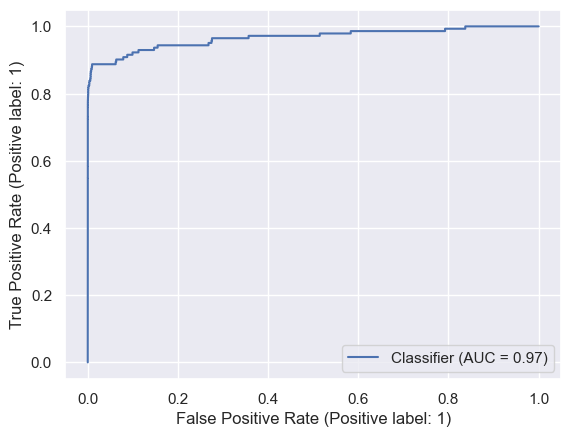

In [16]:
RocCurveDisplay.from_predictions(y_test, baseline.predict_proba(X_test)[:,1])

Если бы мы судили о качестве модели исключительно по ROC кривой, то ошибочно бы пришли к заключению, что наша модель хороша

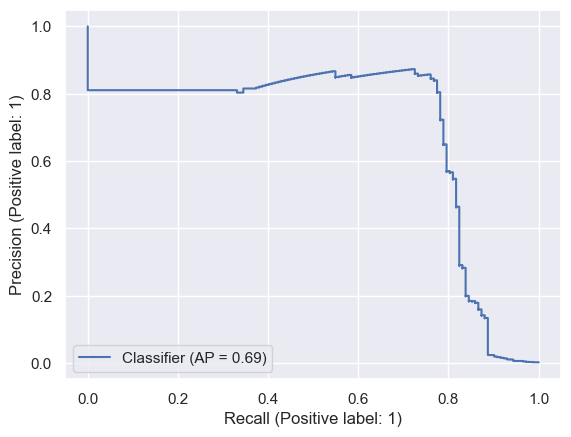

In [17]:
PrecisionRecallDisplay.from_predictions(y_test, baseline.predict_proba(X_test)[:,1])

По precision-recall кривой видно, что модель далека от совершенства

# Модификации решения

Попробуем преобразовать столбец `amount`. Идея: взять логарифм

<AxesSubplot: ylabel='Amount'>

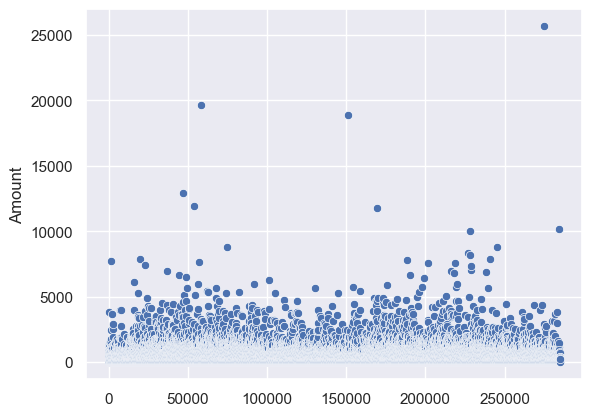

In [18]:
sns.scatterplot(df['Amount'])

<AxesSubplot: >

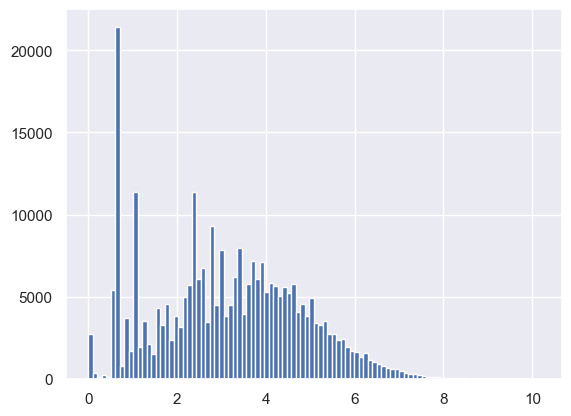

In [19]:
np.log1p(df['Amount']).hist(bins = 100)

In [20]:
df_modify = df.copy()
df_modify['log_amount'] = np.log1p(df['Amount'])

<!-- Разделим `log_amount` на несколько категорий:
- very_small - значение от 0 до 1
- small - значение от 1 до 2
- medium - значение от 2 до 3
- large - значение от 3 до 4
- very_large - значение от 4 -->

In [21]:
# df_modify['Amount_cathegory'] = df_modify['log_amount'].apply(lambda x: 'very_large' if x > 4 
#                             else ('large' if (x > 3) & (x <= 4) 
#                             else ('medium' if (x > 2) & (x < 3)
#                             else ('small' if (x > 1) & (x < 2)
#                             else 'very_small'))))

In [22]:
df_modify

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,log_amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,5.014760
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,1.305626
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,5.939276
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,4.824306
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,4.262539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0,0.570980
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0,3.249987
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0,4.232366
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0,2.397895


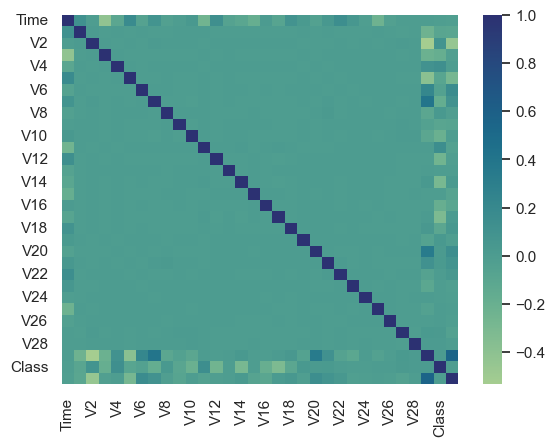

In [23]:
sns.heatmap(df_modify.corr(), cbar=True, cmap="crest")
plt.show()

In [44]:
X = df_modify.drop(['Class'], axis = 1)
y = df_modify.Class

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

second_iteration = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(class_weight = 'balanced'))
])

second_iteration.fit(X_train, y_train)
pred = second_iteration.predict(X_test)

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     84976
           1       0.05      0.89      0.10       142

    accuracy                           0.97     85118
   macro avg       0.53      0.93      0.54     85118
weighted avg       1.00      0.97      0.98     85118



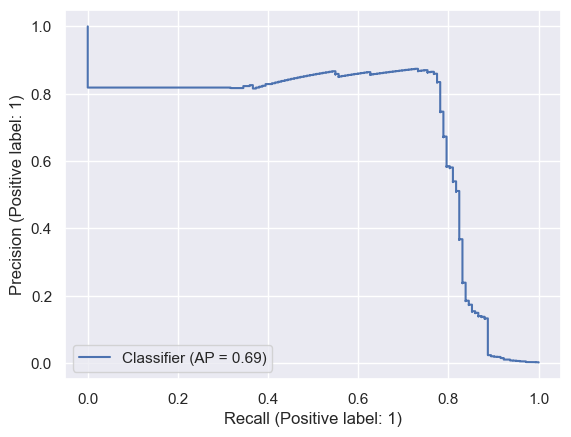

In [45]:
PrecisionRecallDisplay.from_predictions(y_test, second_iteration.predict_proba(X_test)[:,1])

На итоговое качество добавление нового признака не повлияло

Попробуем использовать другую модель

In [25]:
X = df_modify.drop(['Class'], axis = 1)
y = df_modify.Class

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

ss = StandardScaler()

X_train_trans = ss.fit_transform(X_train)
X_test_trans = ss.transform(X_test)

cb = CatBoostClassifier(verbose = 0)
cb.fit(X_train_trans, y_train,
       plot = True)

pred = cb.predict(X_test)

print(classification_report(y_test, pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.86      0.75      0.80       142

    accuracy                           1.00     85118
   macro avg       0.93      0.87      0.90     85118
weighted avg       1.00      1.00      1.00     85118



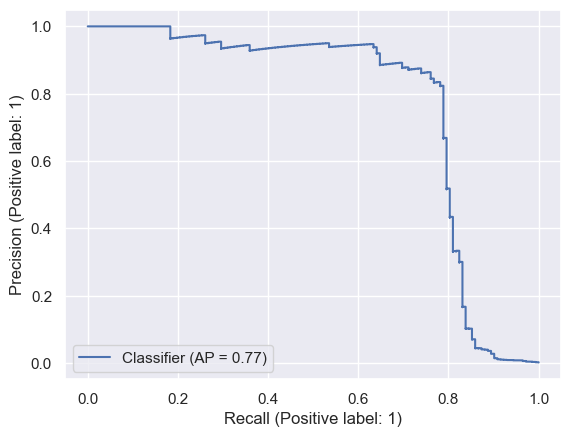

In [27]:
PrecisionRecallDisplay.from_predictions(y_test, cb.predict_proba(X_test)[:,1])

catboost демонстрирует очень хорошие результаты даже с параметрами по умолчанию

Попробуем подобрать гиперпараметры при помощи фреймворка Optuna

In [33]:
def objective_xgb(trial):
    max_depth = trial.suggest_int('max_depth', 2, 12)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log = True)
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1, 10)
    
    score =  cross_val_score(CatBoostClassifier(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators),
                                          X_train, y_train, cv = 3, scoring='f1', n_jobs=-1).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective_xgb, n_trials=50)

[I 2023-11-24 16:48:00,022] A new study created in memory with name: no-name-f3b87d75-3574-44d4-977a-98facf7bc576
[I 2023-11-24 16:50:08,221] Trial 0 finished with value: 0.8669714680744093 and parameters: {'max_depth': 10, 'learning_rate': 0.01978284082912804, 'n_estimators': 588, 'l2_leaf_reg': 5.615464127496213}. Best is trial 0 with value: 0.8669714680744093.
[I 2023-11-24 16:50:28,047] Trial 1 finished with value: 0.8053271366580819 and parameters: {'max_depth': 3, 'learning_rate': 0.002897737149700677, 'n_estimators': 809, 'l2_leaf_reg': 1.1612416676463013}. Best is trial 0 with value: 0.8669714680744093.
[I 2023-11-24 16:50:48,651] Trial 2 finished with value: 0.8588820627164476 and parameters: {'max_depth': 3, 'learning_rate': 0.06252199690803065, 'n_estimators': 792, 'l2_leaf_reg': 7.013510865030421}. Best is trial 0 with value: 0.8669714680744093.
[I 2023-11-24 16:50:57,375] Trial 3 finished with value: 0.0 and parameters: {'max_depth': 6, 'learning_rate': 8.131650227724019e-

[I 2023-11-24 17:52:39,789] Trial 33 finished with value: 0.8385885112363419 and parameters: {'max_depth': 2, 'learning_rate': 0.058009167160714345, 'n_estimators': 580, 'l2_leaf_reg': 2.0362225017493127}. Best is trial 15 with value: 0.869482151835093.
[I 2023-11-24 17:53:27,827] Trial 34 finished with value: 0.8620804669585157 and parameters: {'max_depth': 8, 'learning_rate': 0.0329309204340054, 'n_estimators': 652, 'l2_leaf_reg': 3.5161801462043494}. Best is trial 15 with value: 0.869482151835093.
[I 2023-11-24 17:56:27,120] Trial 35 finished with value: 0.8616856059110448 and parameters: {'max_depth': 10, 'learning_rate': 0.018406236656750116, 'n_estimators': 757, 'l2_leaf_reg': 1.7440120464722808}. Best is trial 15 with value: 0.869482151835093.
[I 2023-11-24 17:58:04,612] Trial 36 finished with value: 0.8667101827051044 and parameters: {'max_depth': 9, 'learning_rate': 0.06258985251522545, 'n_estimators': 894, 'l2_leaf_reg': 2.617046558872266}. Best is trial 15 with value: 0.8694

In [40]:
study.best_params

{'max_depth': 7,
 'learning_rate': 0.09447535241105193,
 'n_estimators': 711,
 'l2_leaf_reg': 3.6356874976666007}

In [42]:
best_cb = CatBoostClassifier(**study.best_params, verbose = 0)
best_cb.fit(X_train, y_train, plot=True)

pred = best_cb.predict(X_test)

print(classification_report(y_test, pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.96      0.73      0.83       142

    accuracy                           1.00     85118
   macro avg       0.98      0.86      0.91     85118
weighted avg       1.00      1.00      1.00     85118



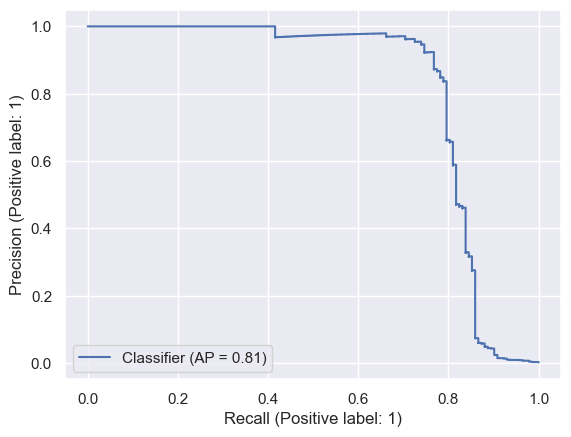

In [43]:
PrecisionRecallDisplay.from_predictions(y_test, best_cb.predict_proba(X_test)[:,1])

При помощи байесовского поиска гиперпараметров удалось поднять качество метрики Precision, сохранив при этом значения Recall.

Это видно и из PrecisionRecall кривой, значение AUC увеличилось с 0.77 до 0.81